<a href="https://colab.research.google.com/github/amun83/Koscom-FinancialDataCamp/blob/master/FD102_Forecasting_Natural_Gas_ETN_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
ON_COLAB = True
DATA_PATH = ''

In [0]:
!pip install -q fbprophet --upgrade
!pip install -q pandas_datareader --upgrade
!pip install -q finance-datareader --upgrade
!pip install -q html5lib --upgrade
!pip install -q lxml --upgrade
!pip install -q gspread --upgrade

In [0]:
# utilities
import datetime
import re
from IPython.display import display

# web scraping
import requests
import urllib.parse
from bs4 import BeautifulSoup
import pandas_datareader as pdr
import FinanceDataReader as fdr

# Math/Stat
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


## Summary

### ETF/ETN@KRX
* 신한 천연가스 선물 ETN(H)
* 신한 레버리지 천연가스 선물 ETN(H)
* 신한 인버스 천연가스 선물 ETN(H)
* 신한 인버스 2X 천연가스 선물 ETN(H)
* 삼성 레버리지 천연가스 선물 ETN
* 삼성 인버스 2X 천연가스 선물 ETN

### Data
* Henry Hub Spot
* NYMEX Futures
* EIA 재고량, 생산량
* NOAA Arctic Oscillation Index
* Bloomberg 미국 기온
* CHECK Dow Jones Commodity Index Natural Gas TR
* CHECK US Dollar Index
* CHECK Crude Oil WTI Futures
* CFTC Non-Commercial Net Positions

### Data Sources
* https://www.investing.com/commodities/natural-gas
* https://www.eia.gov/naturalgas/data.php
* http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao_index.html
* https://www.barchart.com/futures/quotes/NG*0/technical-chart?plot=BAR&volume=0&data=MN&density=X&pricesOn=1&asPctChange=0&logscale=0&indicators=COTLC;COTDLC&sym=NGZ18&grid=1&height=375&studyheight=100

### Methods
* Correlation Matrix
* Facebook Prophet (ARIMA)

## 데이터 준비 I

In [0]:
if ON_COLAB :
  from google.colab import drive
  drive.mount('/gdrive')
  DATA_PATH = '/gdrive/My Drive/Natural Gas Data/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Dow Jones Commodity Index Natural Gas TR
with open(DATA_PATH + 'DJCI.csv', 'r') as f:
  df_DJCI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_DJCI.head(3), df_DJCI.tail(3)]))

,Dow Jones Commodity Index Natural Gas TR,Dow Jones Commodity Index Natural Gas ER,Dow Jones Commodity Index Natural Gas
Effective date,,,
2018-11-16,0.85,0.60,233.33
2018-11-15,0.80,0.56,219.85
2018-11-14,0.97,0.68,266.34
2008-11-04,21.64,15.70,392.55
2008-11-03,20.50,14.87,371.83
2008-10-31,20.33,14.75,368.84


In [0]:
# Henry Hub Natural Gas Spot
with open(DATA_PATH + 'NG_Spot.csv', 'r') as f:
  df_Spot = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Spot.head(3), df_Spot.tail(3)]))
  

,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
2018-11-09,3.74
2018-11-12,3.96
2018-11-13,4.10


In [0]:
# NYMEX Natural Gas Futures
with open(DATA_PATH + 'NG_Futures.csv', 'r') as f:
  df_Futures = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Futures.head(3), df_Futures.tail(3)]))


,Natural Gas Futures Contract 1 (Dollars per Million Btu),Natural Gas Futures Contract 2 (Dollars per Million Btu),Natural Gas Futures Contract 3 (Dollars per Million Btu),Natural Gas Futures Contract 4 (Dollars per Million Btu)
Date,,,,
1993-12-20,NaN,NaN,NaN,1.894
1993-12-21,NaN,NaN,NaN,1.830
1993-12-22,NaN,NaN,NaN,1.859
2018-11-12,3.788,3.800,3.660,3.293
2018-11-13,4.101,4.147,4.019,3.712
2018-11-14,4.837,4.898,4.770,4.472


In [0]:
# EIA Weekly Natural Gas Storage Report
with open(DATA_PATH + 'NG_Storage.csv', 'r') as f:
  df_Storage = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Storage.head(3), df_Storage.tail(3)]))

,Source,East Region,Midwest Region,Mountain Region,Pacific Region,South Central Region,Salt,NonSalt,Total Lower 48
Week ending,,,,,,,,,
2010-01-01,Derived EIA Weekly Estimates,769,900,195,268,985,159,826,3117
2010-01-08,Derived EIA Weekly Estimates,703,820,185,257,886,123,763,2850
2010-01-15,Derived EIA Weekly Estimates,642,750,176,246,793,91,702,2607
2018-10-26,EIA-912,826,956,180,262,919,234,686,3143
2018-11-02,EIA-912,831,980,182,265,949,253,696,3208
2018-11-09,EIA-912,835,991,181,266,974,272,702,3247


In [0]:
# EIA Monthly Gross Withdrawals and Production
with open(DATA_PATH + 'Production.csv', 'r') as f:
  df_Production = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Production.head(3), df_Production.tail(3)]))

,U.S. Natural Gas Gross Withdrawals (MMcf),U.S. Natural Gas Gross Withdrawals from Gas Wells (MMcf),U.S. Natural Gas Gross Withdrawals from Oil Wells (MMcf),U.S. Natural Gas Gross Withdrawals from Shale Gas (Million Cubic Feet),U.S. Natural Gas Gross Withdrawals from Coalbed Wells (MMcf),U.S. Natural Gas Repressuring (MMcf),U.S. Natural Gas Vented and Flared (MMcf),U.S. Nonhydrocarbon Gases Removed from Natural Gas (MMcf),U.S. Natural Gas Marketed Production (MMcf),U.S. Natural Gas Plant Liquids Production (Million Cubic Feet),U.S. Dry Natural Gas Production (MMcf),Unnamed: 12
Date,,,,,,,,,,,,
1973-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948000,79000,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962000,79000,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1907000,77000,NaN,NaN
2018-06-01,2954943.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2641008,187394,2453614.0,NaN
2018-07-01,3106695.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2782326,197213,2585113.0,NaN
2018-08-01,3178843.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2843746,203516,2640230.0,NaN


In [0]:
# US Temperature
with open(DATA_PATH + 'Temperature.csv', 'r') as f:
  df_Temperature = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Temperature.head(3), df_Temperature.tail(3)]))

,Avg,Min,Max
Date,,,
2018-11-19,15.82,11.43,20.20
2018-11-18,15.48,11.03,19.93
2018-11-17,15.91,11.38,20.44
2013-11-29,14.48,9.06,19.90
2013-11-28,13.96,8.75,19.17
2013-11-27,14.47,9.53,19.40


In [0]:
# NOAA Arctic Oscillation Index
with open(DATA_PATH + 'AO_Index.csv', 'r') as f:
  df_AOI = pd.read_csv(f, header = None, index_col = 0, parse_dates = [[0, 1, 2]])
  display(pd.concat([df_AOI.head(3), df_AOI.tail(3)])) 

,3
0_1_2,
1979-01-01,-1.556
1979-01-02,-0.888
1979-01-03,0.255
2018-10-29,0.508
2018-10-30,0.754
2018-10-31,0.776


In [0]:
# Crude Oil WTI Futures
with open(DATA_PATH + 'WTI_Futures.csv', 'r') as f:
  df_WTI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_WTI.head(3), df_WTI.tail(3)]))  

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-11-19,56.98,57.31,57.55,56.83,-,-0.56%
2018-11-18,57.30,57.00,57.36,56.93,-,1.49%
2018-11-16,56.46,56.58,57.96,55.89,159.00K,0.00%
1990-01-04,23.41,23.90,23.92,22.83,53.07K,-1.14%
1990-01-03,23.68,23.19,23.80,23.00,50.06K,3.45%
1990-01-02,22.89,21.81,22.92,21.79,45.18K,4.90%


In [0]:
# US Dollar Index
with open(DATA_PATH + 'Dollar_Index.csv', 'r') as f:
  df_DI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_DI.head(3), df_DI.tail(3)]))

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-11-19,96.36,96.45,96.57,96.32,-,-0.07%
2018-11-18,96.43,96.43,96.45,96.38,-,-0.04%
2018-11-16,96.47,97.05,97.06,96.40,-,-0.47%
1990-01-03,94.42,94.15,94.52,94.08,-,0.14%
1990-01-02,94.29,93.13,94.31,93.08,-,1.16%
1990-01-01,93.21,93.19,93.31,93.08,-,0.00%


## 데이터 준비 II : CFTC  Non-Commercial  Net Positions
* https://colab.research.google.com/drive/1YvdML1V_0VCqwkPCny528AIPjCZUbIYw

In [0]:
# CFTC Weekly Non-Commercial Net Positions
with open(DATA_PATH + 'CFTC.csv', 'r') as f:
  df_CFTC = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_CFTC.head(3), df_CFTC.tail(3)]))
  # COTDLC (M)

,COTDLC (M),COTDLC (O),COTDLC (P),COTDLC (S),COTLC (C),COTLC (L),COTLC (S),Interest,Volume,close,high,low,open,symbol
date,,,,,,,,,,,,,,
2018-11-21,279113,-256767,-50347,-9794,-60141,22346,37795,NaN,NaN,5,5,5,5,NGZ18
2018-11-20,279113,-256767,-50347,-9794,-60141,22346,37795,NaN,697315.0,5,5,4,5,NGZ18
2018-11-19,279113,-256767,-50347,-9794,-60141,22346,37795,1381403.0,805724.0,5,5,4,5,NGZ18
2012-11-05,36281,-85285,-40316,48164,7848,-49004,41156,1175941.0,217603.0,4,4,4,4,NGZ12
2012-11-02,36281,-85285,-40316,48164,7848,-49004,41156,1185202.0,290111.0,4,4,4,4,NGZ12
2012-11-01,36281,-85285,-40316,48164,7848,-49004,41156,1185202.0,272918.0,4,4,4,4,NGZ12


## 데이터 통합

In [0]:
M = pd.concat([ df_DJCI['Dow Jones Commodity Index Natural Gas TR'],
                df_Spot,
                df_Futures['Natural Gas Futures Contract 1 (Dollars per Million Btu)'],
                df_Storage['Total Lower 48'],
                df_Production['U.S. Natural Gas Gross Withdrawals (MMcf)'],
                df_Temperature['Avg'],
                df_AOI,
                df_WTI['Price'],
                df_DI['Price'],
                df_CFTC['COTDLC (M)'] ], axis = 1)

M.columns = ['DJCI', 'Spot', 'Futures', 'Storage', 'Production', 'Temperature', 'AOI', 'WTI', 'DI', 'CFTC']

M.tail(10)

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
2018-11-12,0.76,3.96,3.788,NaN,NaN,16.20,NaN,59.93,97.54,245106.0
2018-11-13,0.82,4.10,4.101,NaN,NaN,15.82,NaN,55.69,97.30,279113.0
2018-11-14,0.97,NaN,4.837,NaN,NaN,15.25,NaN,56.25,96.80,279113.0
2018-11-15,0.80,NaN,NaN,NaN,NaN,15.45,NaN,56.46,96.93,279113.0
2018-11-16,0.85,NaN,NaN,NaN,NaN,15.79,NaN,56.46,96.47,279113.0
2018-11-17,NaN,NaN,NaN,NaN,NaN,15.91,NaN,NaN,NaN,NaN
2018-11-18,NaN,NaN,NaN,NaN,NaN,15.48,NaN,57.30,96.43,NaN
2018-11-19,NaN,NaN,NaN,NaN,NaN,15.82,NaN,56.98,96.36,279113.0
2018-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279113.0
2018-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279113.0


In [0]:
M.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14642 entries, 1973-01-01 to 2018-11-21
Data columns (total 10 columns):
DJCI           2532 non-null float64
Spot           5500 non-null float64
Futures        6230 non-null float64
Storage        463 non-null float64
Production     464 non-null float64
Temperature    1819 non-null float64
AOI            14548 non-null float64
WTI            7312 non-null float64
DI             7486 non-null float64
CFTC           1526 non-null float64
dtypes: float64(10)
memory usage: 1.2 MB


In [0]:
M.isnull().sum()

DJCI           12110
Spot            9142
Futures         8412
Storage        14179
Production     14178
Temperature    12823
AOI               94
WTI             7330
DI              7156
CFTC           13116
dtype: int64

## 결측 데이터 처리

In [0]:
M['DJCI'       ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['Spot'       ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['Futures'    ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['Storage'    ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['Temperature'].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['AOI'        ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['WTI'        ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['DI'         ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['CFTC'       ].interpolate(method = 'nearest', limit_direction='forward', inplace = True)



In [0]:
M['Production'] = M['Production'].apply(lambda x : x / 30)
M['Production'].fillna(method = 'ffill', inplace = True)

M.tail(10)

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
2018-11-12,0.76,3.96,3.788,3247.0,105961.433333,16.20,0.776,59.93,97.54,245106.0
2018-11-13,0.82,4.10,4.101,3247.0,105961.433333,15.82,0.776,55.69,97.30,279113.0
2018-11-14,0.97,4.10,4.837,3247.0,105961.433333,15.25,0.776,56.25,96.80,279113.0
2018-11-15,0.80,4.10,4.837,3247.0,105961.433333,15.45,0.776,56.46,96.93,279113.0
2018-11-16,0.85,4.10,4.837,3247.0,105961.433333,15.79,0.776,56.46,96.47,279113.0
2018-11-17,0.85,4.10,4.837,3247.0,105961.433333,15.91,0.776,56.88,96.45,279113.0
2018-11-18,0.85,4.10,4.837,3247.0,105961.433333,15.48,0.776,57.30,96.43,279113.0
2018-11-19,0.85,4.10,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0
2018-11-20,0.85,4.10,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0
2018-11-21,0.85,4.10,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0


## 데이터 개괄

In [0]:
M.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14642 entries, 1973-01-01 to 2018-11-21
Data columns (total 10 columns):
DJCI           3674 non-null float64
Spot           7989 non-null float64
Futures        9079 non-null float64
Storage        3247 non-null float64
Production     14205 non-null float64
Temperature    1821 non-null float64
AOI            14570 non-null float64
WTI            10551 non-null float64
DI             10552 non-null float64
CFTC           2212 non-null float64
dtypes: float64(10)
memory usage: 1.2 MB


In [0]:
M.describe()

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
count,3674.000000,7989.000000,9079.000000,3247.000000,14205.000000,1821.000000,14570.000000,10551.000000,10552.000000,2212.000000
mean,3.065479,4.350068,4.130159,2751.877117,68359.138160,19.021367,0.065590,47.463728,90.734435,21282.443038
std,3.467201,2.239771,2.259480,762.209232,11902.194247,3.042696,1.374333,29.794834,10.221746,112375.326876
min,0.510000,1.050000,1.323000,824.000000,48331.933333,11.170000,-5.125000,10.720000,71.330000,-233984.000000
25%,0.790833,2.773333,2.509500,2216.714286,60200.000000,16.350000,-0.806750,21.018333,82.669167,-61612.000000
50%,1.851667,3.730000,3.459333,2813.714286,66234.200000,19.460000,0.139000,37.000000,89.475000,20664.000000
75%,4.018333,5.480000,5.165333,3352.785714,71834.700000,21.890000,1.021000,69.295000,96.330000,110113.000000
max,21.730000,18.480000,15.378000,4047.000000,105961.433333,23.760000,4.635000,145.290000,120.900000,279113.000000


In [0]:
M.isnull().sum()

DJCI           10968
Spot            6653
Futures         5563
Storage        11395
Production       437
Temperature    12821
AOI               72
WTI             4091
DI              4090
CFTC           12430
dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


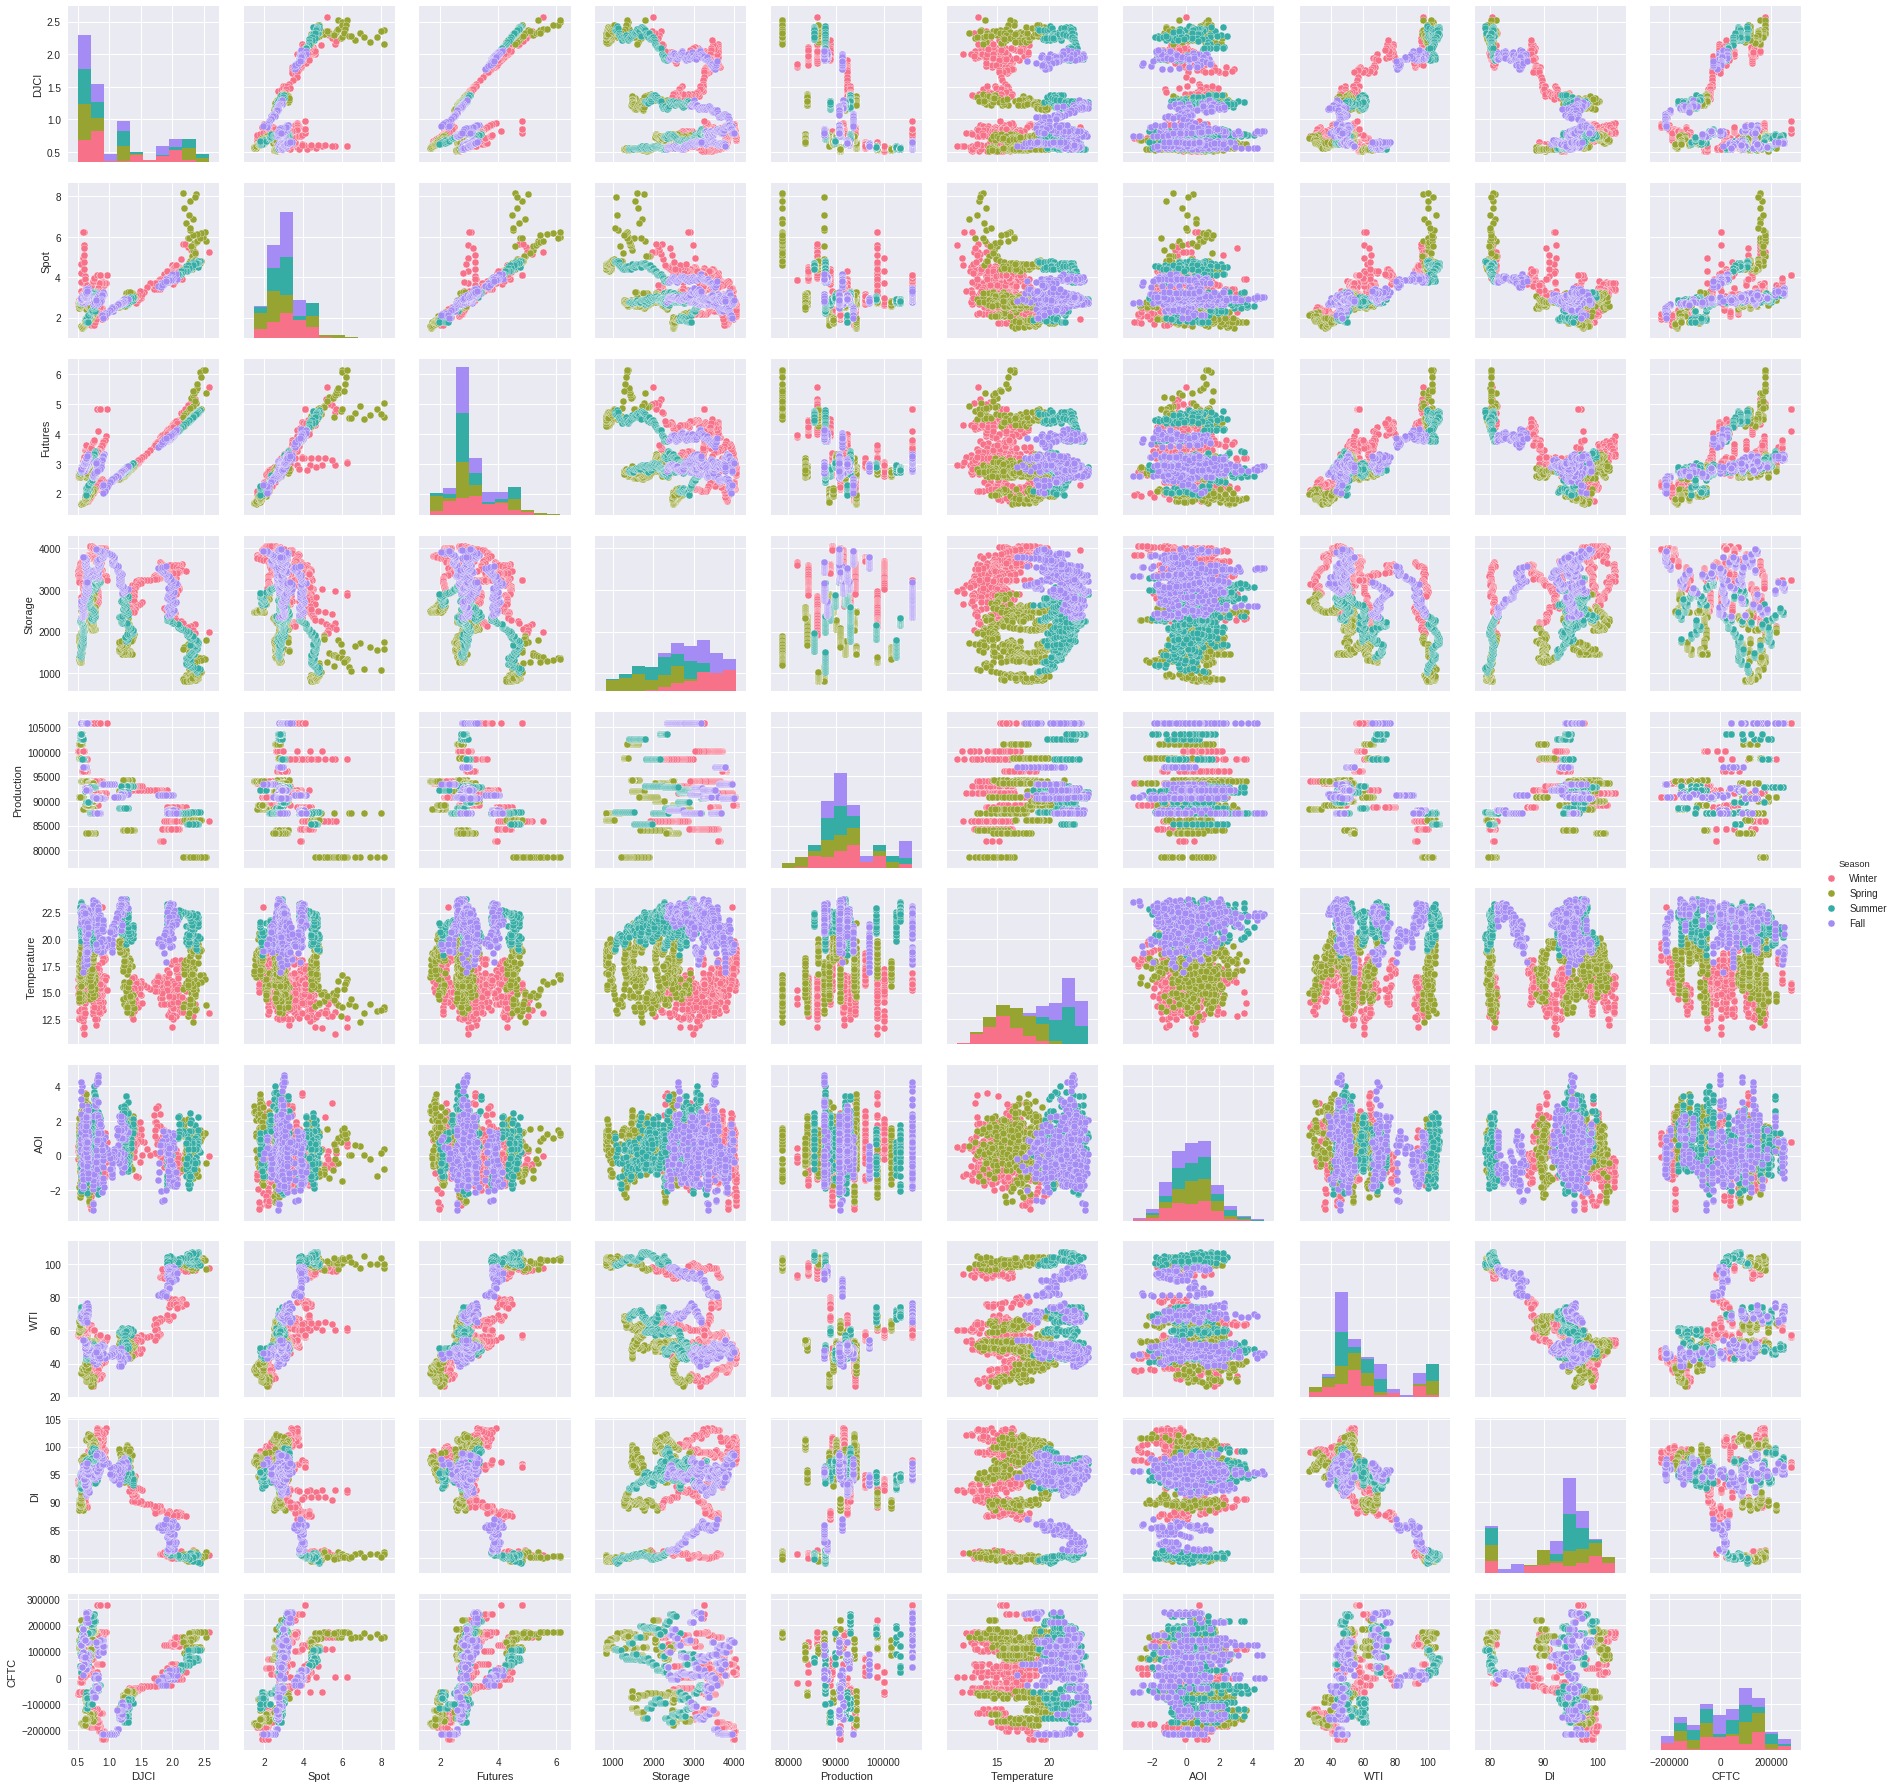

In [0]:
m2season = {  2 : 'Spring' , 5 : 'Summer' ,  8 : 'Fall' , 11 : 'Winter' ,
              3 : 'Spring' , 6 : 'Summer' ,  9 : 'Fall' , 12 : 'Winter' ,
              4 : 'Spring' , 7 : 'Summer' , 10 : 'Fall' ,  1 : 'Winter' }

tmp = M.dropna()
tmp['Season'] = tmp.index.map(lambda x : m2season[x.month])

sns.pairplot(tmp, hue='Season', palette='husl')


In [0]:
M.corr()

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
DJCI,1.000000,0.618417,0.681397,-0.125854,-0.701748,-0.103397,-0.025075,-0.025884,-0.425911,-0.044322
Spot,0.618417,1.000000,0.988277,-0.276017,-0.361658,-0.195695,-0.124539,0.348041,-0.344889,0.460761
Futures,0.681397,0.988277,1.000000,-0.233870,-0.242878,-0.139386,-0.099954,0.434207,-0.285762,0.478743
Storage,-0.125854,-0.276017,-0.233870,1.000000,0.022566,0.039559,-0.048074,-0.200692,0.109401,-0.323145
Production,-0.701748,-0.361658,-0.242878,0.022566,1.000000,0.132875,0.114384,0.506466,-0.081623,0.222701
Temperature,-0.103397,-0.195695,-0.139386,0.039559,0.132875,1.000000,0.041976,-0.017509,0.056092,-0.087283
AOI,-0.025075,-0.124539,-0.099954,-0.048074,0.114384,0.041976,1.000000,0.024807,0.024869,-0.101715
WTI,-0.025884,0.348041,0.434207,-0.200692,0.506466,-0.017509,0.024807,1.000000,-0.614320,0.263510
DI,-0.425911,-0.344889,-0.285762,0.109401,-0.081623,0.056092,0.024869,-0.614320,1.000000,-0.087705
CFTC,-0.044322,0.460761,0.478743,-0.323145,0.222701,-0.087283,-0.101715,0.263510,-0.087705,1.000000


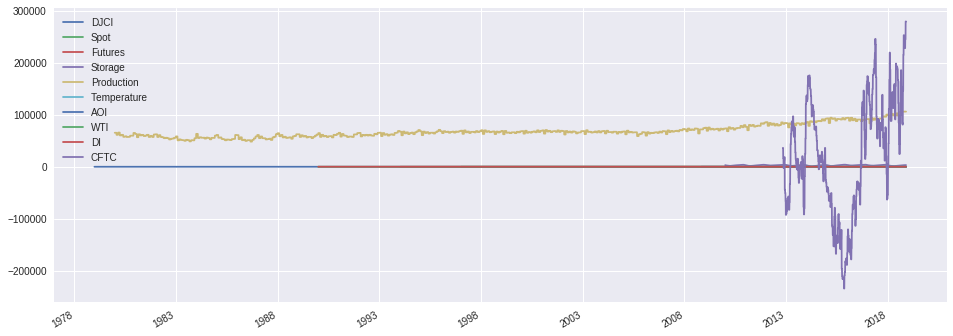

In [0]:
M.plot(figsize = (16, 6))

## 데이터 정규화

In [0]:
N = M.dropna().apply(scale, axis = 'index', raw = True)
N.head(5)

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
2013-11-27,1.237635,0.871219,1.049906,1.211157,-1.820233,-1.496245,-0.373158,1.543324,-1.918831,-0.372865
2013-11-28,1.263193,0.871219,1.089324,1.182330,-1.820233,-1.663905,-0.659500,1.542334,-1.918831,-0.372865
2013-11-29,1.288752,0.871219,1.128742,1.153503,-1.820233,-1.492957,-0.465050,1.564114,-1.925151,-0.372865
2013-11-30,1.300112,0.863356,1.143886,1.139267,-1.820233,-1.252972,0.037894,1.582263,-1.912511,-0.372865
2013-12-01,1.311471,0.855492,1.159030,1.125032,-1.412943,-0.983401,0.560529,1.600413,-1.899870,-0.372865


In [0]:
N.describe()

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
count,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1.821000e+03,1821.000000,1.821000e+03,1.821000e+03,1.821000e+03
mean,1.248620e-16,-2.185085e-16,-2.029007e-16,-4.682324e-16,3.340058e-15,-1.794891e-16,0.000000,1.560775e-16,9.364649e-17,-6.243099e-17
std,1.000275e+00,1.000275e+00,1.000275e+00,1.000275e+00,1.000275e+00,1.000275e+00,1.000275,1.000275e+00,1.000275e+00,1.000275e+00
min,-9.774617e-01,-1.936029e+00,-1.964588e+00,-2.320487e+00,-2.385112e+00,-2.581107e+00,-2.917416,-1.728046e+00,-2.176378e+00,-2.165748e+00
25%,-7.559520e-01,-4.852241e-01,-5.441948e-01,-6.638334e-01,-6.409619e-01,-8.782018e-01,-0.696421,-6.988028e-01,-4.488611e-01,-7.560387e-01
50%,-5.003640e-01,-2.375257e-01,-2.497828e-01,8.459672e-02,-1.316849e-01,1.441988e-01,-0.020359,-3.864659e-01,2.995541e-01,1.348919e-01
75%,3.856745e-01,3.640274e-01,3.595298e-01,7.796438e-01,2.964425e-01,9.430520e-01,0.656524,3.959438e-01,6.487443e-01,7.855201e-01
max,2.532614e+00,5.919547e+00,4.061727e+00,1.694095e+00,2.342957e+00,1.557807e+00,3.470714,2.283825e+00,1.648914e+00,2.089588e+00


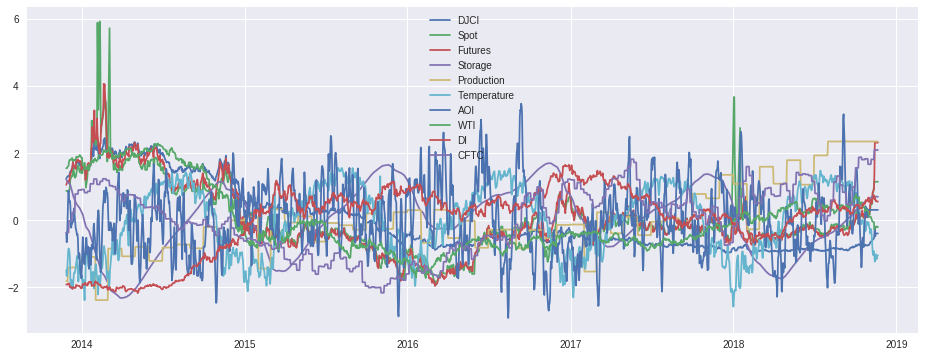

In [0]:
N.plot(figsize = (16, 6))

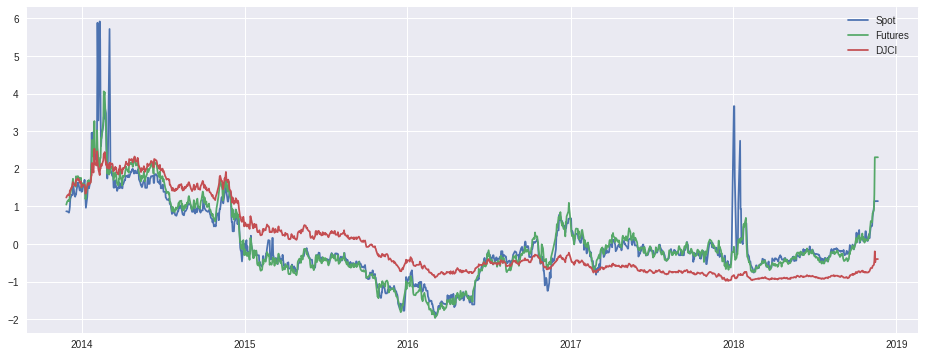

In [0]:
N[['Spot', 'Futures', 'DJCI']].plot(figsize = (16, 6))

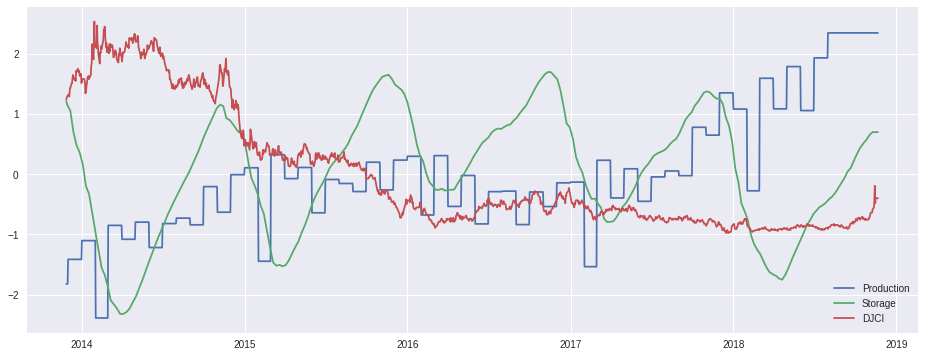

In [0]:
N[['Production', 'Storage', 'DJCI']].plot(figsize = (16, 6))

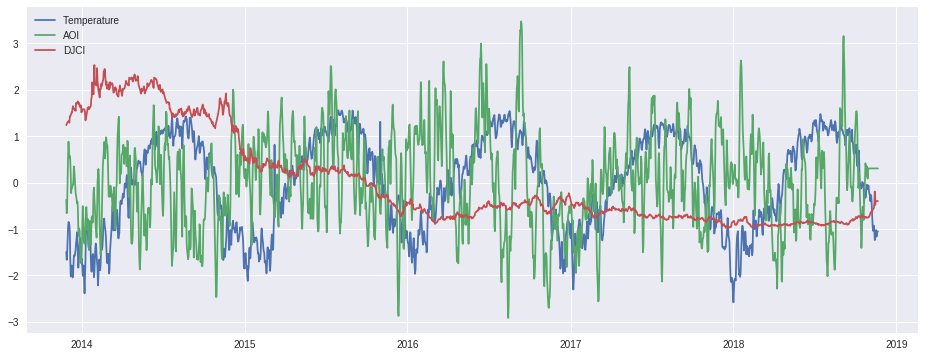

In [0]:
N[['Temperature', 'AOI', 'DJCI']].plot(figsize = (16, 6))

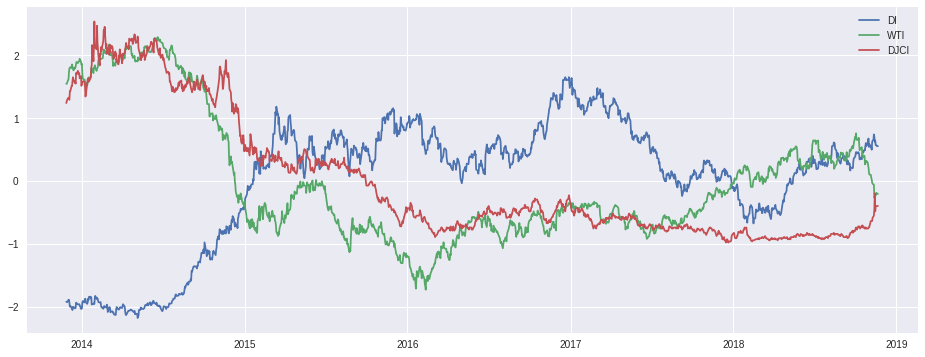

In [0]:
N[['DI', 'WTI', 'DJCI']].plot(figsize = (16, 6))

## Facebook Prophet 시계열 분석

In [0]:
M1 = M.reset_index()
M1.rename(columns={'index':'ds', 'DJCI' :'y'}, inplace=True)

M1.dropna(inplace=True)

M1.head(5)

,ds,y,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
12821,2013-11-27,1.810000,3.870000,3.895000,3659.285714,81838.966667,14.47,-0.050,92.300000,80.72,-17803.0
12822,2013-11-28,1.825000,3.870000,3.924500,3636.142857,81838.966667,13.96,-0.399,92.280000,80.72,-17803.0
12823,2013-11-29,1.840000,3.870000,3.954000,3613.000000,81838.966667,14.48,-0.162,92.720000,80.68,-17803.0
12824,2013-11-30,1.846667,3.863333,3.965333,3601.571429,81838.966667,15.21,0.451,93.086667,80.76,-17803.0
12825,2013-12-01,1.853333,3.856667,3.976667,3590.142857,84198.900000,16.03,1.088,93.453333,80.84,-17803.0


In [0]:
fb1 = Prophet(daily_seasonality=True, changepoint_prior_scale=0.5, yearly_seasonality=20)
fb1.fit(M1)

In [0]:
future1 = fb1.make_future_dataframe(periods=90)
future1.tail()

,ds
1906,2019-02-15
1907,2019-02-16
1908,2019-02-17
1909,2019-02-18
1910,2019-02-19


In [0]:
forecast1 = fb1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1906,2019-02-15,0.760089,0.558984,0.981241
1907,2019-02-16,0.763571,0.558879,1.002982
1908,2019-02-17,0.766590,0.569999,1.003546
1909,2019-02-18,0.768600,0.562927,1.002252
1910,2019-02-19,0.775183,0.545577,1.028493


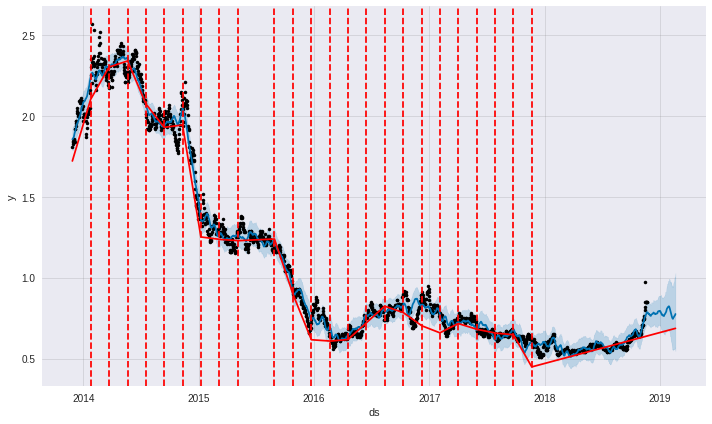

In [0]:
fig1 = fb1.plot(forecast1)
_ = add_changepoints_to_plot(fig1.gca(), fb1, forecast1)

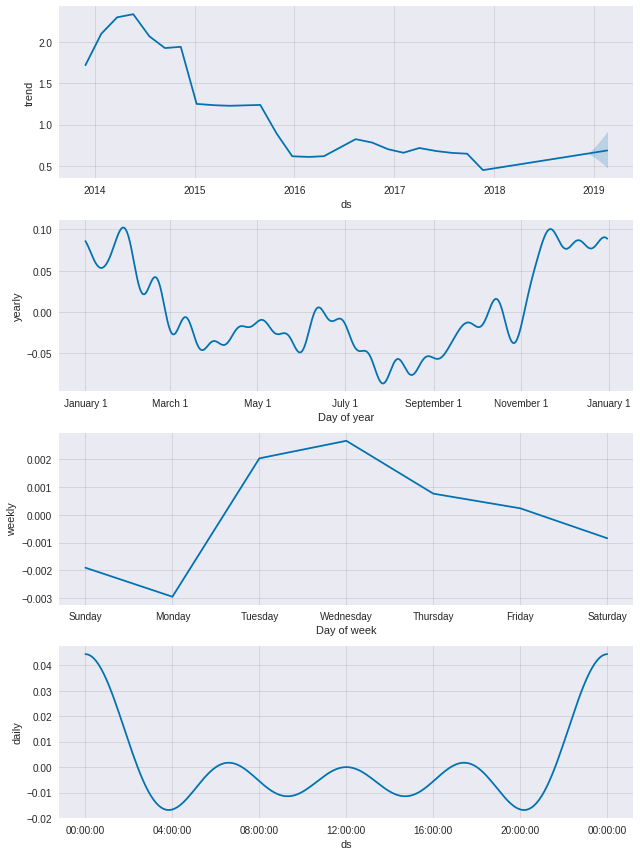

In [0]:
_ = fb1.plot_components(forecast1)

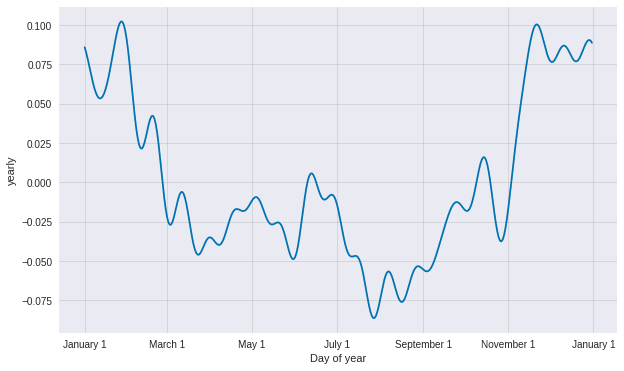

In [0]:
_ = plot_yearly(fb1)

In [0]:
df_cv1 = cross_validation(fb1, initial='360 days', period='90 days', horizon = '180 days')
df_cv1.head()

INFO:fbprophet.diagnostics:Making 15 forecasts with cutoffs between 2014-12-12 00:00:00 and 2018-05-25 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-12-13,1.717811,1.667977,1.764566,1.786667,2014-12-12
1,2014-12-14,1.705123,1.655362,1.755737,1.773333,2014-12-12
2,2014-12-15,1.690134,1.642437,1.737465,1.760000,2014-12-12
3,2014-12-16,1.688554,1.639657,1.741307,1.720000,2014-12-12
4,2014-12-17,1.667890,1.621335,1.716765,1.760000,2014-12-12


In [0]:
df_p1 = performance_metrics(df_cv1)
df_p1.head()

,horizon,mse,rmse,mae,mape,coverage
197,18 days,0.011912,0.109143,0.082261,0.102957,0.518519
18,19 days,0.011918,0.109168,0.082299,0.103030,0.518519
738,19 days,0.011998,0.109537,0.082724,0.103525,0.514815
2358,19 days,0.012017,0.109622,0.082935,0.103970,0.511111
198,19 days,0.011964,0.109380,0.082669,0.103565,0.514815


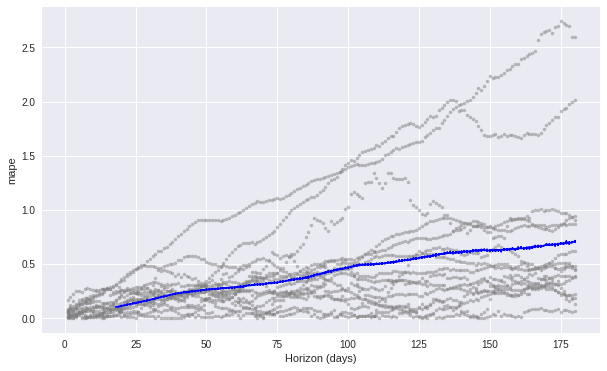

In [0]:
_ = plot_cross_validation_metric(df_cv1, metric='mape')

### 2016년부터 재분석

In [0]:
M1[M1['ds'] == '2016-01-01']

,ds,y,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
13586,2016-01-01,0.83,2.28,2.33625,3643.0,94103.466667,15.33,1.429,36.97,98.63,-166391.0


In [0]:
fb2 = Prophet(daily_seasonality=True, changepoint_prior_scale=0.5, yearly_seasonality=20)
fb2.fit(M1.loc[13586:])

In [0]:
future2 = fb2.make_future_dataframe(periods=90)
future2.tail()

,ds
1141,2019-02-15
1142,2019-02-16
1143,2019-02-17
1144,2019-02-18
1145,2019-02-19


In [213]:
forecast2 = fb2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][forecast2['ds'] == '2018-11-22']

,ds,yhat,yhat_lower,yhat_upper
1056,2018-11-22,0.891645,0.864055,0.921031


### Dow Jones Commodity Index Natural Gas@2018-11-22
* https://kr.spindices.com/indices/commodities/dow-jones-commodity-index-natural-gas

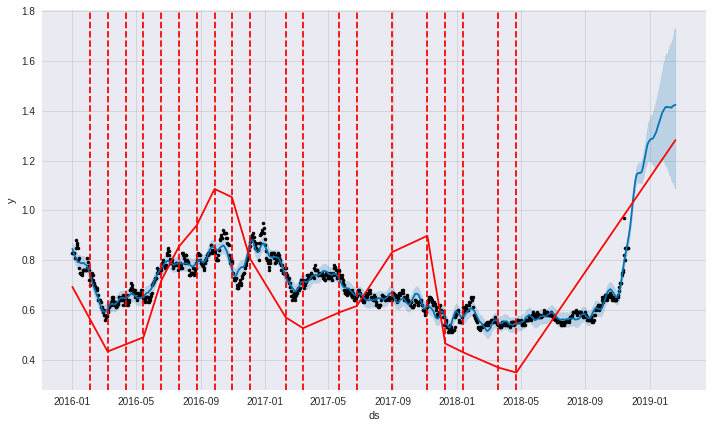

In [0]:
fig2 = fb2.plot(forecast2)
_ = add_changepoints_to_plot(fig2.gca(), fb2, forecast2)

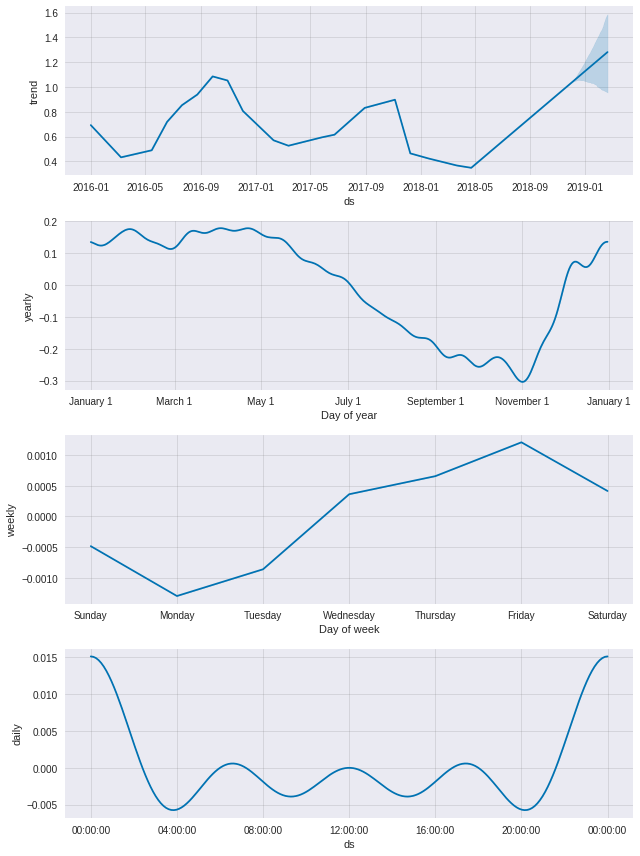

In [0]:
_ = fb2.plot_components(forecast2)

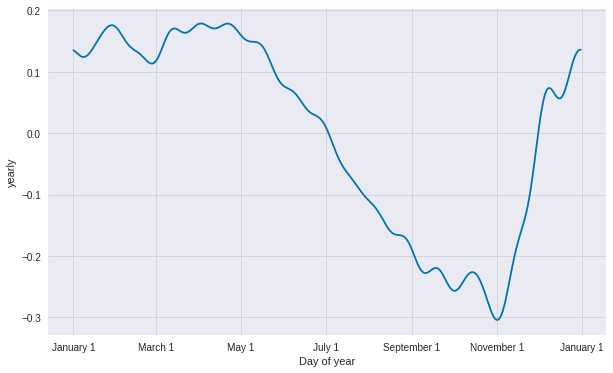

In [0]:
_ = plot_yearly(fb2)

In [0]:
df_cv2 = cross_validation(fb2, initial='360 days', period='90 days', horizon = '180 days')
df_cv2.head()

INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2017-03-01 00:00:00 and 2018-05-25 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-02,0.632548,0.610428,0.655629,0.670000,2017-03-01
1,2017-03-03,0.632864,0.609811,0.655166,0.680000,2017-03-01
2,2017-03-04,0.633210,0.610241,0.655511,0.683333,2017-03-01
3,2017-03-05,0.635113,0.613297,0.656733,0.686667,2017-03-01
4,2017-03-06,0.638373,0.613620,0.660992,0.690000,2017-03-01


In [0]:
df_p2 = performance_metrics(df_cv2)
df_p2.head()

,horizon,mse,rmse,mae,mape,coverage
377,18 days,0.007191,0.084801,0.061049,0.098801,0.425926
18,19 days,0.007188,0.084783,0.061006,0.098705,0.425926
198,19 days,0.007575,0.087034,0.062545,0.100959,0.425926
558,19 days,0.007737,0.087963,0.063552,0.102995,0.416667
378,19 days,0.007724,0.087886,0.063290,0.102529,0.425926


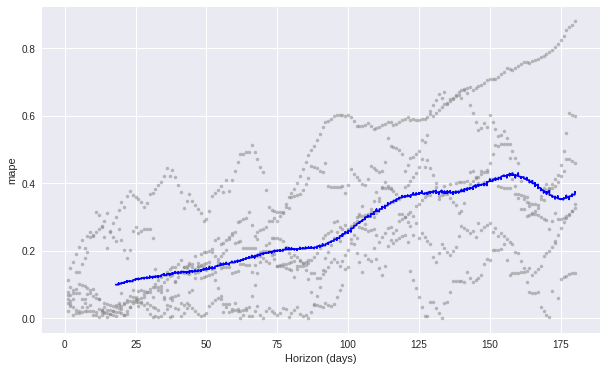

In [0]:
_ = plot_cross_validation_metric(df_cv2, metric='mape')

# EOF